# Price Prediction


## Description
The target variable is price. There are 7 attributes and need to build some initial ML model which predicts the prices.

- Make some initial data analysis, which will hint to some stuctures in the data and how attributes are connected.
- Fit some ML model(s) and explain briefly the choices.
- Show with some X-validation the power ofmodel and comment the results.
- Present the results and the steps you have taken and also with some critical thinking and next steps.

- data preprocessing: improving data quality
- important features: list of features sorted by their gini-importance from high to low
- Model Selection: test different models (illustarte their pros), choose the best performance model with highest score (RSME, R2)
- Hyperparameter tuning and optimization: use gridsearch to find the optimal parameters for the model
- According to the result, consider employ DL

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(df.shape)
    display(df.head())
    print(df.info())
    return df 


original = load_data('../data/sample.csv')

(10000, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB
None


The df info shows there is no null value.

I'm wondering why 'loc1' and 'loc2' are objects? It seems their values are numerical.

And I'm suspicous that 'para1' is a binary feature. 

In the following cell I will double check the unique value of these three features and update their dtype if necessary.

In [3]:
def check_unique_values(df, check_lst):
    for col in check_lst:
        print(f'number of unique values of {col}: {df[col].nunique()}')
        print(f'unique values of {col}: {df[col].unique()}')
    return None

check_lst = ['loc1', 'loc2', 'para1','dow']
check_unique_values(original, check_lst)
        

number of unique values of loc1: 12
unique values of loc1: ['0' '9' '4' '5' '7' '8' '1' '3' '2' '6' 'S' 'T']
number of unique values of loc2: 107
unique values of loc2: ['01' '99' '04' '40' '50' '03' '09' '74' '89' '17' '34' '30' '21' '59'
 '28' '64' '14' '46' '19' '15' '90' '67' '85' '24' '12' '20' '23' '08'
 '06' '95' '37' '77' '73' '88' '66' '39' '41' '68' '47' '33' '35' '78'
 '54' '76' '51' '79' '16' '02' '29' '57' '45' '80' '31' '70' '22' '27'
 '87' '53' '75' '38' '26' '25' '63' '86' '97' '81' '13' '49' '32' '72'
 '71' '10' '94' '96' '93' '42' '48' '55' '91' '58' '60' '44' '52' '05'
 '36' '82' '56' '84' '65' '07' '92' '83' '18' '69' '98' '62' '00' '61'
 '0B' 'S6' '43' '0T' 'TS' '0L' '11' '0C' '0N']
number of unique values of para1: 13
unique values of para1: [  1   0   4   3   2   5  24   7   6  13   9   8 337]
number of unique values of dow: 7
unique values of dow: ['Mon' 'Thu' 'Tue' 'Wed' 'Fri' 'Sat' 'Sun']


Looks 'loc1' and 'loc2' are mainly numeric values.
Check values that are not numeric.

In [4]:
loc1st = original[(original['loc1'] == 'S') | (original['loc1'] == 'T')]
display(loc1st)
print(len(loc1st))

loc2stirng = original[original['loc2'].apply(lambda x: x in ['0B','S6','0T','TS','0L','0C','0N'])]
display(loc2stirng)
print(len(loc2stirng))


,loc1,loc2,para1,dow,para2,para3,para4,price
3026,S,S6,3,Fri,1289,24000.0,13.6,850.0
5510,T,TS,3,Fri,1472,1600.0,2.0,440.0


2


,loc1,loc2,para1,dow,para2,para3,para4,price
2887,0,0B,2,Mon,801,1091.0,9.0,1350.0
3026,S,S6,3,Fri,1289,24000.0,13.6,850.0
4850,0,0T,2,Mon,1473,4000.0,2.0,1890.0
5510,T,TS,3,Fri,1472,1600.0,2.0,440.0
5647,0,0L,2,Wed,1127,10000.0,13.6,750.0
7751,0,0C,3,Fri,623,1500.0,6.0,400.0
8466,0,0N,3,Fri,1298,3500.0,2.1,1500.0


7


Only few abnormal values, I will drop them and convert 'loc1' 'loc2' to numeric features.

In [5]:
def drop_incorrect(input_df):
    df = input_df[input_df['loc2'].apply(lambda x: x not in ['0B','S6','0T','TS','0L','0C','0N'])]
    print(df.shape)
    display(df.head())
    return df 

uploc = drop_incorrect(original)
    

(9993, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [6]:
# double check the unique values of loc1 and loc2
check_lst = ['loc1', 'loc2']
check_unique_values(uploc, check_lst)

number of unique values of loc1: 10
unique values of loc1: ['0' '9' '4' '5' '7' '8' '1' '3' '2' '6']
number of unique values of loc2: 100
unique values of loc2: ['01' '99' '04' '40' '50' '03' '09' '74' '89' '17' '34' '30' '21' '59'
 '28' '64' '14' '46' '19' '15' '90' '67' '85' '24' '12' '20' '23' '08'
 '06' '95' '37' '77' '73' '88' '66' '39' '41' '68' '47' '33' '35' '78'
 '54' '76' '51' '79' '16' '02' '29' '57' '45' '80' '31' '70' '22' '27'
 '87' '53' '75' '38' '26' '25' '63' '86' '97' '81' '13' '49' '32' '72'
 '71' '10' '94' '96' '93' '42' '48' '55' '91' '58' '60' '44' '52' '05'
 '36' '82' '56' '84' '65' '07' '92' '83' '18' '69' '98' '62' '00' '61'
 '43' '11']


All anomaly are removed from loc1 and loc2, now convert them to int.

In [7]:
def update_dtype(indf, cols, dtype):
    df = indf.copy()
    for col in cols:
        df[col] = df[col].astype(dtype)
    print(df.info())
    return df

df = update_dtype(uploc, ['loc1', 'loc2'], 'int')


<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    9993 non-null   int64  
 1   loc2    9993 non-null   int64  
 2   para1   9993 non-null   int64  
 3   dow     9993 non-null   object 
 4   para2   9993 non-null   int64  
 5   para3   9993 non-null   float64
 6   para4   9993 non-null   float64
 7   price   9993 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 702.6+ KB
None


Now we can process feature transformation for categorical features, which is 'dow'.

We will use get_dummies function to encode it.

In [8]:
def get_dummy(indf, col):
    data = pd.get_dummies(indf, columns=[col], prefix=col, dtype='int')
    print(data.shape)
    display(data.head())
    return data

transDF = get_dummy(df, 'dow')

(9993, 14)


,loc1,loc2,para1,para2,para3,para4,price,dow_Fri,dow_Mon,dow_Sat,dow_Sun,dow_Thu,dow_Tue,dow_Wed
0,0,1,1,662,3000.0,3.8,73.49,0,1,0,0,0,0,0
1,9,99,1,340,2760.0,9.2,300.00,0,0,0,0,1,0,0
2,0,4,0,16,2700.0,3.0,130.00,0,1,0,0,0,0,0
3,4,40,1,17,12320.0,6.4,365.00,0,1,0,0,0,0,0
4,5,50,1,610,2117.0,10.8,357.50,0,0,0,0,1,0,0


Since we don't have null values, so we don't need to impute numerical features.

# Check Correlation and Outliers
I need to check correlations and outliers to enable a better ML training.

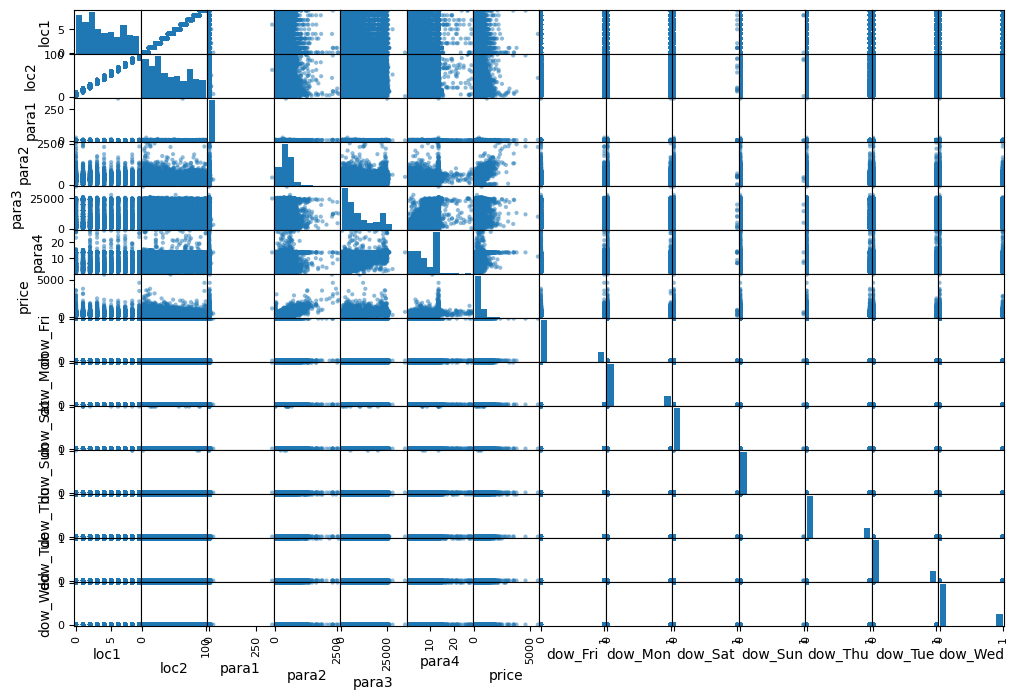

In [9]:
from pandas.plotting import scatter_matrix

_ =scatter_matrix(transDF, figsize=(12, 8))

looks loc1 and loc2 are correlated with each other, I will use the correlation with price to determine which one should be dropped.

Before compute the correlation, need to check their distribution to determine the suitable correlation method.

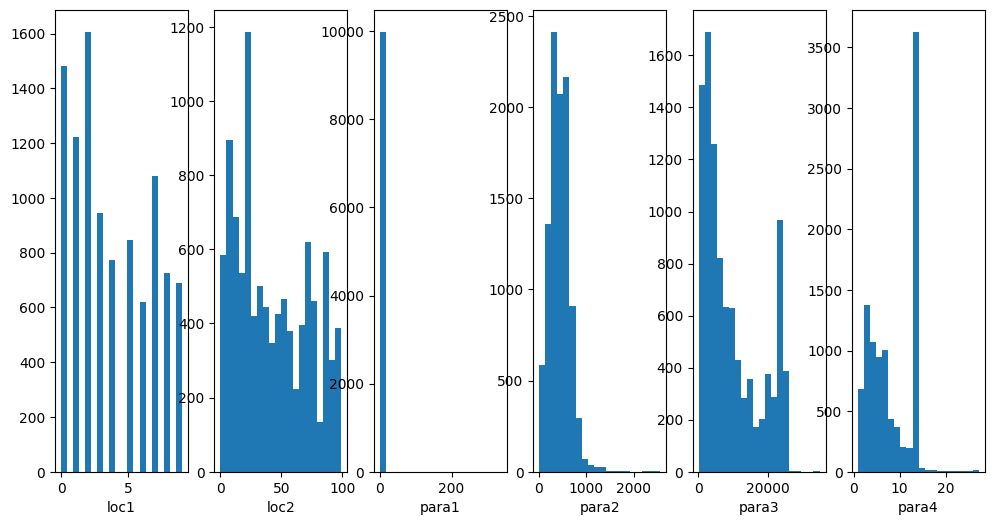

In [10]:
corr_lst = [x for x in transDF.columns[:6]]

fig, ax = plt.subplots(1,6, figsize=(12, 6))
for i, col in enumerate(corr_lst):
    ax[i].hist(transDF[col], bins=20)
    ax[i].set_xlabel(col)


None of these features appear a normal distribution, hence I will use spreasman' correlation.

In [11]:
import numpy as np
def corr_df(indf):
    df = indf.copy()
    corr = df.corr(method = 'spearman')
    corr = corr.apply(lambda x: np.abs(x))
    corr.sort_values(by='price', ascending=False, inplace=True) 
    return corr['price'][1:]

corr = corr_df(transDF)
corr

para4      0.635457
para3      0.463335
para2      0.449945
para1      0.137897
loc2       0.034366
dow_Wed    0.033558
dow_Thu    0.029687
loc1       0.028848
dow_Mon    0.024798
dow_Fri    0.020667
dow_Tue    0.017691
dow_Sat    0.015298
dow_Sun    0.009893
Name: price, dtype: float64

Seems loc1 has more correlation than loc2, hence I will drop loc1.

In [12]:
def drop(indf, cols):
    df = indf.drop(cols, axis=1)
    print(df.shape)
    display(df.head())
    return df

updf_corr = drop(transDF, 'loc1')


(9993, 13)


,loc2,para1,para2,para3,para4,price,dow_Fri,dow_Mon,dow_Sat,dow_Sun,dow_Thu,dow_Tue,dow_Wed
0,1,1,662,3000.0,3.8,73.49,0,1,0,0,0,0,0
1,99,1,340,2760.0,9.2,300.00,0,0,0,0,1,0,0
2,4,0,16,2700.0,3.0,130.00,0,1,0,0,0,0,0
3,40,1,17,12320.0,6.4,365.00,0,1,0,0,0,0,0
4,50,1,610,2117.0,10.8,357.50,0,0,0,0,1,0,0


In [13]:
# now check outliers using df.describe()

updf_corr.describe()

,loc2,para1,para2,para3,para4,price,dow_Fri,dow_Mon,dow_Sat,dow_Sun,dow_Thu,dow_Tue,dow_Wed
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.00000,9993.000000
mean,42.468028,1.379966,446.888522,9550.105894,8.460614,433.318379,0.192835,0.191734,0.001001,0.000300,0.190934,0.19984,0.223356
std,29.350079,3.501891,220.141080,8022.655794,4.613156,276.743453,0.394544,0.393685,0.031620,0.017325,0.393057,0.39990,0.416516
min,0.000000,0.000000,16.000000,200.000000,1.000000,50.730000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,16.000000,1.000000,301.000000,2900.000000,4.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,37.000000,1.000000,434.000000,6448.000000,7.200000,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,69.000000,1.000000,582.000000,15000.000000,13.600000,550.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,99.000000,337.000000,2554.000000,34782.000000,27.200000,5700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


It seems para1 has really big value 337 which is way bigger than mean, I will double check the para1's value descendingly.

In [14]:
display(updf_corr['para1'].sort_values(ascending=False).head(10))
updf_corr['para1'].value_counts()

7196    337
1561     24
8328     13
4522     13
7198      9
5928      9
6249      8
4848      7
2152      7
2838      7
Name: para1, dtype: int64

para1
1      7052
3      1609
0       836
2       265
4       164
5        51
6         6
7         3
13        2
9         2
24        1
8         1
337       1
Name: count, dtype: int64

Looks 337 is an abnormal value, I will drop this value from entire dataset.

In [15]:
def drop_outliers(indf, col, threshold):
    df = indf[indf[col] < threshold]
    print(df.shape)
    display(df.head())
    return df

df = drop_outliers(updf_corr, 'para1', 337)


(9992, 13)


,loc2,para1,para2,para3,para4,price,dow_Fri,dow_Mon,dow_Sat,dow_Sun,dow_Thu,dow_Tue,dow_Wed
0,1,1,662,3000.0,3.8,73.49,0,1,0,0,0,0,0
1,99,1,340,2760.0,9.2,300.00,0,0,0,0,1,0,0
2,4,0,16,2700.0,3.0,130.00,0,1,0,0,0,0,0
3,40,1,17,12320.0,6.4,365.00,0,1,0,0,0,0,0
4,50,1,610,2117.0,10.8,357.50,0,0,0,0,1,0,0


# Feature Selection

Eventhough it's not a high-dimension dataset, but I will select three sets of features based on the correaltion value with price for better performance.

In [16]:
corr = corr_df(df)
corr

para4      0.635399
para3      0.463186
para2      0.449995
para1      0.137583
loc2       0.034484
dow_Wed    0.033474
dow_Thu    0.029611
dow_Mon    0.024463
dow_Fri    0.020751
dow_Tue    0.017778
dow_Sat    0.015305
dow_Sun    0.009897
Name: price, dtype: float64

In [17]:
corr.index[:5].to_list()

['para4', 'para3', 'para2', 'para1', 'loc2']

In [18]:
features_dic = {
    'top4': corr.index[:5].to_list(),
    'top8': corr.index[:10].to_list(),
    'all_features': corr.index.to_list()
}

# Machine learning models

Iterate 6 models and measure their performance and to identify the model with best performance.

6 models are:
- Rridge
- Decision Tree
- Random Forest
- XGBoost
- LightGBM
- MLP

I will measure the score of both train and test dataset, and also use rsme to compare the performance between models.

In [19]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

models_dic = {
    "Ridge": Ridge(random_state=42),
    "Decision_Tree": DecisionTreeRegressor(random_state=42),
    "Random_Forest": RandomForestRegressor(random_state=42),
    "LGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "MLP": MLPRegressor(random_state=42)
}

In [20]:
from sklearn.metrics import root_mean_squared_error

def train_model(df, model, features, versbose=False):
    X = df[features + ['price']].drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = model
    model.fit(X_train, y_train)

    # scores to check overfitting issue
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # RMSE for comparing models
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    if versbose:
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print(f'RMSE: {rmse}')
    return train_score, test_score, rmse


In [21]:
def model_selection(df):
    model_selection_dic = {}
    model_lst = []
    feature_name_lst = []
    train_score_lst = []
    test_score_lst = []
    rmse_lst = []

    for model, regressor in models_dic.items():
        for feature_name, fea in features_dic.items():
            train_score, test_score, rmse = train_model(df, regressor, fea)
            model_lst.append(model)
            feature_name_lst.append(feature_name)
            train_score_lst.append(train_score)
            test_score_lst.append(test_score)
            rmse_lst.append(rmse)


    model_selection_dic['model'] = model_lst
    model_selection_dic['feature'] = feature_name_lst
    model_selection_dic['train_score'] = train_score_lst
    model_selection_dic['test_score'] = test_score_lst
    model_selection_dic['rmse'] = rmse_lst

    # print(model_selection_dic)
    df = pd.DataFrame(model_selection_dic,index=range(len(rmse_lst)))
    return df

In [22]:
model_df = model_selection(df)
model_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 5
[LightGBM] [Info] Start training from score 431.291006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 10
[LightGBM] [Info] Start training from score 431.291006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 10
[LightGBM] [Info] Start traini

,model,feature,train_score,test_score,rmse
0,Ridge,top4,0.554121,0.598234,173.488541
1,Ridge,top8,0.555587,0.598115,173.514355
2,Ridge,all_features,0.555609,0.598092,173.519173
3,Decision_Tree,top4,0.999771,0.472049,198.875424
4,Decision_Tree,top8,0.999905,0.465286,200.145054
5,Decision_Tree,all_features,0.999905,0.471947,198.894536
6,Random_Forest,top4,0.955010,0.729467,142.362042
7,Random_Forest,top8,0.955850,0.726484,143.144898
8,Random_Forest,all_features,0.955921,0.724215,143.737444
9,LGBM,top4,0.799643,0.707835,147.944432


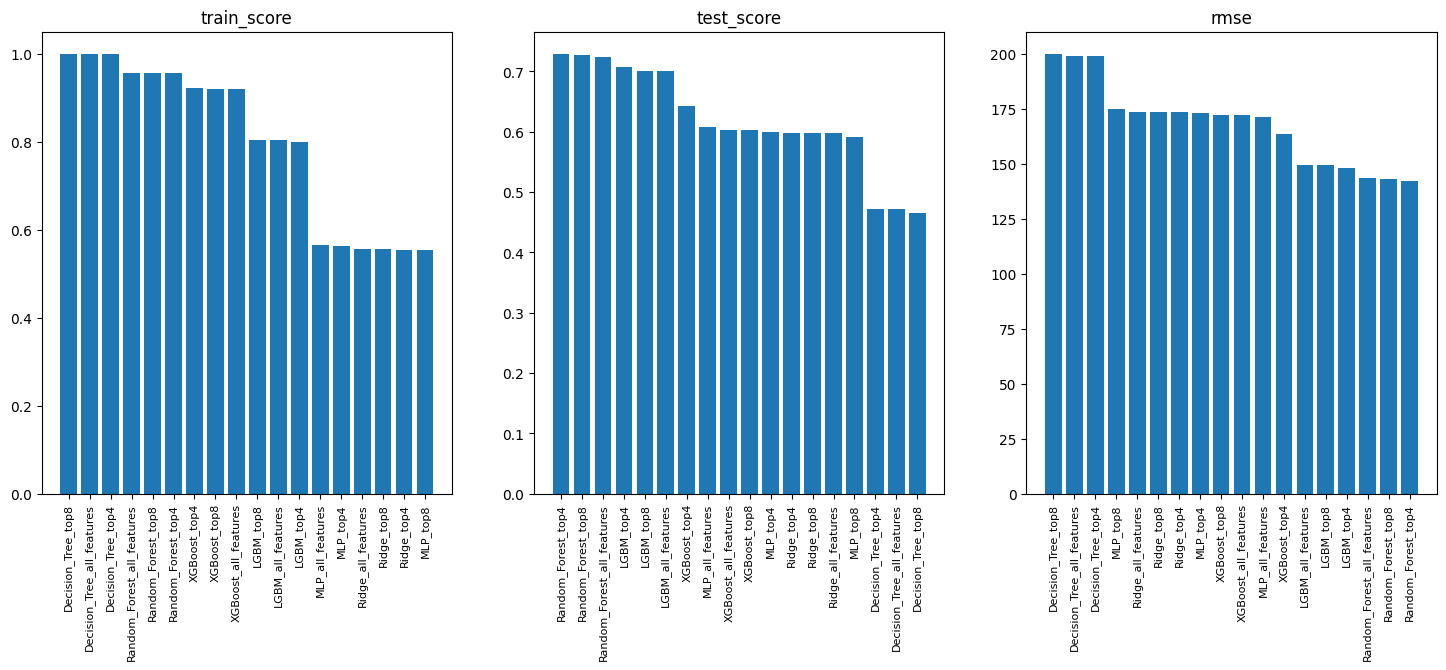

In [23]:
# illusrate the result
modf = model_df.copy()
modf['x_axis'] = modf['model'] + '_' + modf['feature']

fig, ax = plt.subplots(1,3, figsize=(18, 6))
for i, score in enumerate(['train_score', 'test_score', 'rmse']):
    modf.sort_values(by=score,ascending= False, inplace=True)
    ax[i].bar(x= modf['x_axis'], height=modf[score])
    ax[i].set_xticklabels(modf['x_axis'], rotation=90, size = 8)
    ax[i].set_title(score)
    

I will sort the table according to these three scores to identify the most suitable model.

In [24]:
# top5 models with highest score in training 
top5_train = modf.sort_values(by='train_score', ascending=False).head(5)

# top5 models with highet score in testing
top5_test = modf.sort_values(by='test_score', ascending=False).head(5)

# top5 models with lowest RMSE
top5_rmse = modf.sort_values(by='rmse', ascending=True).head(5)

In [25]:
best_model_df = top5_train.merge(top5_test, on ='x_axis', how = 'inner').merge(top5_rmse, on ='x_axis', how = 'inner').sort_values(by='rmse')
best_model_df 

,model_x,feature_x,train_score_x,test_score_x,rmse_x,x_axis,model_y,feature_y,train_score_y,test_score_y,rmse_y,model,feature,train_score,test_score,rmse
1,Random_Forest,top8,0.955850,0.726484,143.144898,Random_Forest_top8,Random_Forest,top8,0.955850,0.726484,143.144898,Random_Forest,top8,0.955850,0.726484,143.144898
0,Random_Forest,all_features,0.955921,0.724215,143.737444,Random_Forest_all_features,Random_Forest,all_features,0.955921,0.724215,143.737444,Random_Forest,all_features,0.955921,0.724215,143.737444


Above results indicate that random forest with all features produce the best performance among other combinations.

# Optimization: Hyperparameter Tuning
I will use hyperparameter tuning to optimize the model.

firstly, I will create a basic model for baseline, then I will use grid search to find the best parameters, then I will employ scalers to chekc which boost a better performance.

In [26]:
from sklearn.model_selection import train_test_split

def basic_model(df, verbose=False, set_params = False, **params):
    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)

    if set_params:
        model.set_params(**params)

    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    rmse = root_mean_squared_error(y_test, model.predict(X_test))

    if verbose:
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print(f'RMSE: {rmse}')

    return train_score, test_score, rmse

In [47]:
model_lst = ['basic_model']

train_score_lst, test_score_lst, rmse_lst = [], [], []
basic_train, basic_test, basic_rmse = basic_model(df, verbose=True)
train_score_lst.append(basic_train)
test_score_lst.append(basic_test)
rmse_lst.append(basic_rmse)


train score: 0.9559397978248616
test score: 0.7260538545684498
RMSE: 143.25732962415327


In [48]:
from sklearn.model_selection import GridSearchCV

def best_parameters(df):
    param_grid = { 
        'n_estimators': [100, 200, 300], #larger trees improve prediction accuracy
        'max_depth': [5, 10, 15, 20],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
    }
    search = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid = param_grid, cv=5)

    X = df.drop('price', axis=1)
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    search.fit(X_train, y_train)
    print(search.best_params_)

    return search.best_params_


best_para = best_parameters(df)   


{'max_depth': 15, 'n_estimators': 300}


In [49]:
model_lst.append('best_model')

best_train, best_test, best_rmse = basic_model(df, verbose=True, set_params=True, **best_para)
train_score_lst.append(best_train)
test_score_lst.append(best_test)
rmse_lst.append(best_rmse)

train score: 0.9305012245052612
test score: 0.7255170591675282
RMSE: 143.39761676207098


# Implementing Scalers
I will test basic model and best model with three different scalers: MinMax, Standard and Robust

In [50]:
def implement_scalar(df, scalar, verbose=False, set_params = False, **params):
    X = df.drop('price', axis=1)
    y = df['price']

    scal = scalar
    X = scal.fit_transform(X)
    y = scal.fit_transform(y.values.reshape(-1,1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)

    if set_params:
        model.set_params(**params)

    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    rmse = root_mean_squared_error(y_test, model.predict(X_test))

    if verbose:
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print(f'RMSE: {rmse}')

    return train_score, test_score, rmse

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler()
}


for scal_name, scal in scalers.items():
    for model in ['basic_model', 'best_model']:
        
        if model == 'basic_model':
            train_score, test_score, rmse = implement_scalar(df, scal, verbose=True)
        else:
            # best_para = best_parameters(df)
            train_score, test_score, rmse = implement_scalar(df, scal, verbose=True, set_params=True, **best_para)

        
        model_lst.append(model + '_' + scal_name)
        train_score_lst.append(train_score)
        test_score_lst.append(test_score)
        rmse_lst.append(rmse)


train score: 0.9558153229187321
test score: 0.7257903103308734
RMSE: 0.5180767565464958
train score: 0.93060604931379
test score: 0.7259600866752376
RMSE: 0.5179163486543206
train score: 0.956296055601342
test score: 0.724738511367089
RMSE: 0.025419362219095753
train score: 0.9308499569137701
test score: 0.7277097377669257
RMSE: 0.025281799205132804
train score: 0.9557603939050365
test score: 0.7236533815453536
RMSE: 0.4796120401336901
train score: 0.9306475400920254
test score: 0.7241658908156842
RMSE: 0.4791670922436467


In [56]:
model_scaler = pd.DataFrame(data = {'model': model_lst, 'train_score': train_score_lst, 'test_score': test_score_lst, 'rmse': rmse_lst})

model_scaler.sort_values(by = 'rmse', ascending= True)


,model,train_score,test_score,rmse
5,best_model_MinMax,0.930850,0.727710,0.025282
4,basic_model_MinMax,0.956296,0.724739,0.025419
7,best_model_Robust,0.930648,0.724166,0.479167
6,basic_model_Robust,0.955760,0.723653,0.479612
3,best_model_Standard,0.930606,0.725960,0.517916
2,basic_model_Standard,0.955815,0.725790,0.518077
0,basic_model,0.955940,0.726054,143.257330
1,best_model,0.930501,0.725517,143.397617


The result indicates that model with `best parameters` and `MinMaxScaler` produced the best performance.
